<a href="https://colab.research.google.com/github/juancspjr/d3colab/blob/main/extraxion_exitosa_modelo_3d(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Paso 1




In [1]:
# ╔════════════════════════════════════════════╗
# ║  0. Setup Avanzado de Compatibilidad       ║
# ╚════════════════════════════════════════════╝
import subprocess, sys
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
def pip(cmd):
    subprocess.check_call([sys.executable, "-m", "pip"] + cmd.split())

# 1️⃣ Limpiar e instalar pip actualizado
pip("install --upgrade pip setuptools")

# 2️⃣ Evitar conflictos: versiones específicas compatibles
pip("install huggingface-hub==0.17.3")
pip("install tokenizers==0.14.1")
pip("install transformers==4.35.0")

# 3️⃣ Instalación robusta del resto de dependencias
deps = [
    "omegaconf==2.3.0",
    "Pillow==10.1.0",
    "einops==0.7.0",
    "trimesh==4.0.5",
    "rembg",
    "imageio[ffmpeg]",
    "gradio",
    "moderngl==5.10.0",
    "xatlas==0.0.9"
]
pip("install " + " ".join(deps))

# 4️⃣ TorchMCubes compilado desde GitHub
pip("install git+https://github.com/tatsy/torchmcubes.git")

print("✓ Todas las dependencias instaladas correctamente")




env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
✓ Todas las dependencias instaladas correctamente


Paso 2


In [2]:
# ╔════════════════════════════════════════════╗
# ║  0b. Descargar y activar TripoSR (sin -e)  ║
# ╚════════════════════════════════════════════╝
import os, sys, subprocess

TRIPOSR_DIR = "/content/TripoSR"

# 1️⃣ Clonar si no existe
if not os.path.exists(TRIPOSR_DIR):
    !git clone https://github.com/camenduru/TripoSR {TRIPOSR_DIR}

# 2️⃣ Agregar TripoSR al sys.path
if TRIPOSR_DIR not in sys.path:
    sys.path.append(TRIPOSR_DIR)

# 3️⃣ Instalar onnxruntime si falta
try:
    import onnxruntime
except ImportError:
    print("📦 Instalando onnxruntime...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnxruntime"])

# 4️⃣ Verificar importación de módulos clave
try:
    from tsr.system import TSR
    from tsr.utils import remove_background, resize_foreground, to_gradio_3d_orientation
    print("✅ TripoSR importado correctamente sin reinicio")
except Exception as e:
    print("❌ Error al importar TripoSR:", str(e))


✅ TripoSR importado correctamente sin reinicio


paso 3


In [3]:
# ╔════════════════════════════════════════════╗
# ║  2. Infraestructura de Eventos             ║
# ╚════════════════════════════════════════════╝
import time
from uuid import uuid4

event_bus = {}

def emit_event(name, payload):
    event = {
        'event_id': str(uuid4()),
        'timestamp': time.time(),
        'event_name': name,
        'payload': payload
    }
    print(f"\n📤 Evento Emitido: {name}")
    if name in event_bus:
        for handler in event_bus[name]:
            handler(event)
    return event

def consume_event(name):
    def decorator(fn):
        if name not in event_bus:
            event_bus[name] = []
        event_bus[name].append(fn)
        return fn
    return decorator


paso 4

In [4]:
assert callable(emit_event)
assert callable(consume_event)
print("✓ Infraestructura de eventos activada")


✓ Infraestructura de eventos activada


paso 5

In [5]:
# ╔════════════════════════════════════════════╗
# ║  2b. Importación de módulos necesarios     ║
# ╚════════════════════════════════════════════╝

import subprocess, sys

def pip(cmd):
    subprocess.check_call([sys.executable, "-m", "pip"] + cmd.split())

try:
    import onnxruntime
except ImportError:
    print("🧩 Instalando dependencia faltante: onnxruntime")
    pip("install onnxruntime")

# Importar módulos clave
import os
import logging
import torch
import numpy as np
from PIL import Image
import rembg
from google.colab import files
from tsr.system import TSR
from tsr.utils import remove_background, resize_foreground, to_gradio_3d_orientation

print("✓ Módulos importados correctamente")


✓ Módulos importados correctamente


paso 6


In [6]:

# ╔════════════════════════════════════════════╗
# ║  3. Configuración                          ║
# ╚════════════════════════════════════════════╝
CHUNK_SIZE = 8192
MC_RESOLUTION = 256
OUTPUT_DIR = "/content/TripoSR/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"🚀 Usando dispositivo: {device}")

@consume_event("SubidaImagenIniciada")
def cargar_modelo(event):
    try:
        print("📥 Cargando modelo TripoSR...")
        model = TSR.from_pretrained("stabilityai/TripoSR", config_name="config.yaml", weight_name="model.ckpt")
        model.eval()
        model.renderer.set_chunk_size(CHUNK_SIZE)
        model.to(device)
        session = rembg.new_session()
        emit_event("ModeloTripoSRCargado", {"model": model, "rembg_session": session, "input_image_path": event['payload']['input_image_path']})
    except Exception as e:
        emit_event("Error", {"step": "cargar_modelo", "error": str(e)})


🚀 Usando dispositivo: cuda:0


Saving camper.png to camper.png

📤 Evento Emitido: SubidaImagenIniciada
📥 Cargando modelo TripoSR...


config.yaml:   0%|          | 0.00/987 [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 60.8GB/s]



📤 Evento Emitido: ModeloTripoSRCargado

📤 Evento Emitido: ImagenPreprocesada
📸 Imagen procesada:


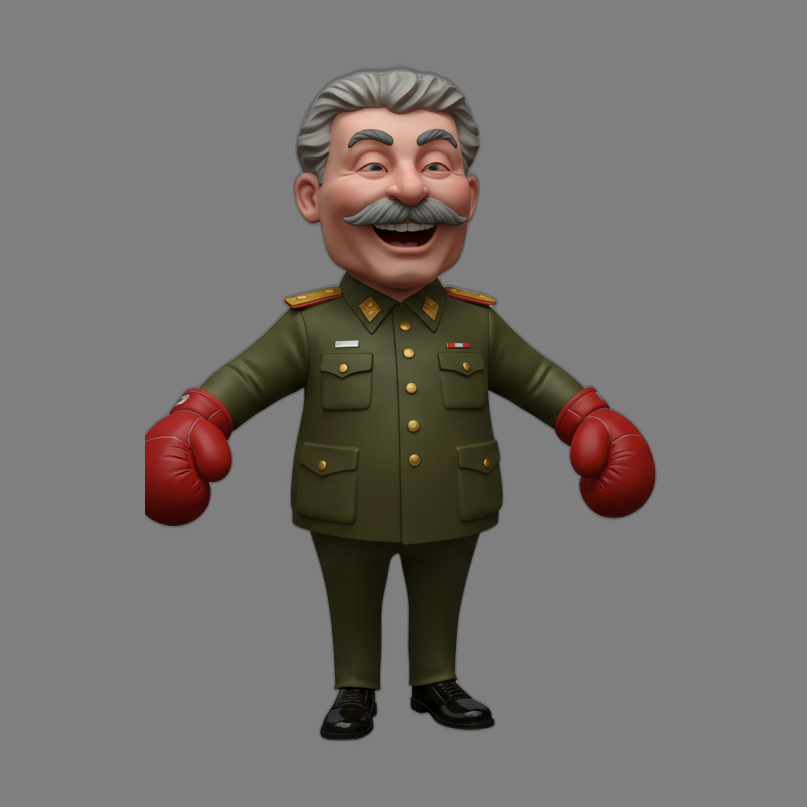

In [8]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    input_path = f"/content/{filename}"
    emit_event("SubidaImagenIniciada", {"input_image_path": input_path})
    break  # Solo una imagen


In [7]:
# ╔════════════════════════════════════════════╗
# ║  5. Procesamiento Imagen                   ║
# ╚════════════════════════════════════════════╝

def fill_background(image):
    image = np.array(image).astype(np.float32) / 255.0
    image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
    return Image.fromarray((image * 255.0).astype(np.uint8))

@consume_event("ModeloTripoSRCargado")
def preprocesar_imagen(event):
    model = event['payload']['model']
    rembg_session = event['payload']['rembg_session']
    input_image_path = event['payload']['input_image_path']

    image = Image.open(input_image_path)
    image = remove_background(image.convert("RGB"), rembg_session)
    image = resize_foreground(image, 0.85)
    image = fill_background(image)

    processed_path = os.path.join(OUTPUT_DIR, "processed_image.png")
    image.save(processed_path)

    emit_event("ImagenPreprocesada", {
        "image_path": processed_path,
        "model": model


    })
    print("📸 Imagen procesada:")
    display(image)  # 👈 Aquí verás la imagen

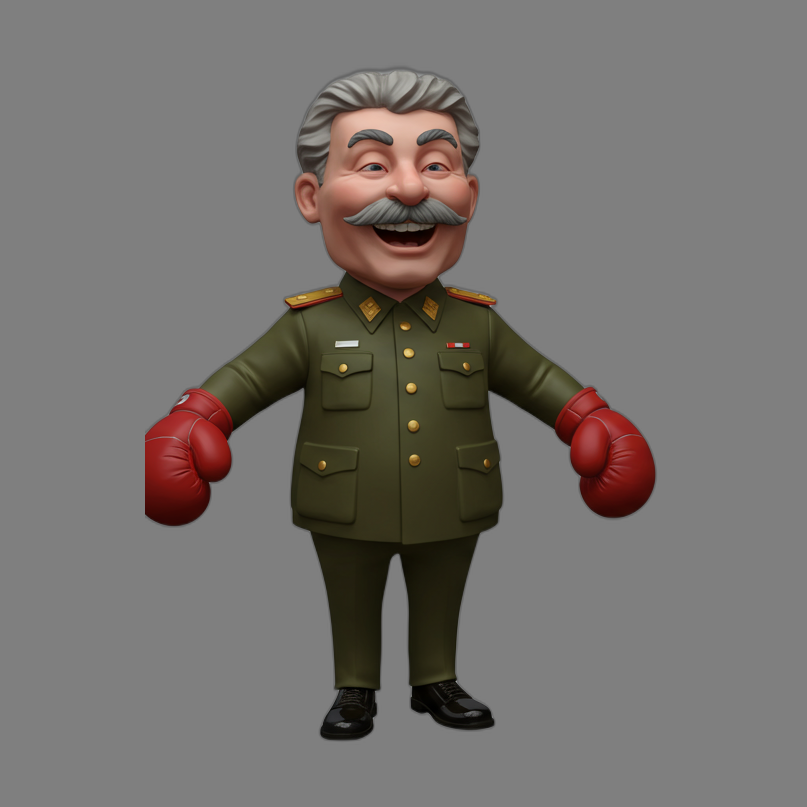

In [ ]:
from IPython.display import display
from PIL import Image

# Muestra la imagen procesada manualmente
img_path = "/content/TripoSR/output/processed_image.png"
if os.path.exists(img_path):
    img = Image.open(img_path)
    display(img)
else:
    print("❌ Imagen procesada no encontrada")


In [13]:
import gc
import psutil

def liberar_memoria():
    print("🧼 Limpieza de memoria: RAM y VRAM...")
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    used_ram = psutil.virtual_memory().used / (1024 ** 3)
    used_vram = torch.cuda.memory_allocated() / 1e9
    print(f"🧠 RAM usada: {used_ram:.2f} GB")
    print(f"🎮 VRAM usada: {used_vram:.2f} GB")

liberar_memoria()

🧼 Limpieza de memoria: RAM y VRAM...
🧠 RAM usada: 4.93 GB
🎮 VRAM usada: 3.30 GB


In [10]:
# ─── Diagnóstico de memoria antes de extract_mesh ────────────────────
import torch

# asumiendo que ya has hecho:
# triplane = model([img], device=DEVICE)

# 1) Forma y dtype de cada tensor en triplane
print("🔍 Triplane info:")
for i, t in enumerate(triplane):
    # si es lista de tensores
    print(f"  Tensor {i}: shape={tuple(t.shape)}, dtype={t.dtype}, device={t.device}")

# 2) Resumen de memoria CUDA completo
print("\n🔍 Memoria CUDA summary:")
print(torch.cuda.memory_summary(device=DEVICE, abbreviated=False))

# 3) Luego ya puedes intentar extraer el mesh (y probablemente falle por OOM)
# mesh, *_ = model.extract_mesh(triplane, resolution=RESOLUTION)


🔍 Triplane info:
  Tensor 0: shape=(3, 40, 64, 64), dtype=torch.float32, device=cuda:0

🔍 Memoria CUDA summary:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   3145 MiB |   7753 MiB |   1027 GiB |   1024 GiB |
|       from large pool |   3142 MiB |   7750 MiB |     31 GiB |     28 GiB |
|       from small pool |      2 MiB |   2053 MiB |    996 GiB |    996 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   31

In [ ]:
import os
os._exit(00)

In [8]:
# ─── Celda Única: Generación Global con Fallback de Resolución ─────────────
import os
import gc
import sys
import shutil
import time
import datetime
import json
import warnings
import importlib

import psutil
import torch
import numpy as np
from PIL import Image
import trimesh
from tsr.system import TSR

# 0) Setup y supresión de warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")
trimesh = importlib.reload(trimesh)

# 1) Configuración
IMAGE_PATH = "/content/camper.png"
RESOLUTION = 512          # resolución objetivo
FALLBACK_RES = 384        # resolución de fallback en caso de OOM
DEVICE     = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TS         = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_ROOT   = f"/content/TripoSR/output_global_{TS}"
os.makedirs(OUT_ROOT, exist_ok=True)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,expandable_segments:True"

def print_mem():
    ram = psutil.virtual_memory()
    v_used = torch.cuda.memory_allocated(DEVICE)/1e9 if DEVICE.type=="cuda" else 0
    v_res  = torch.cuda.memory_reserved(DEVICE)/1e9  if DEVICE.type=="cuda" else 0
    v_tot  = torch.cuda.get_device_properties(DEVICE).total_memory/1e9 if DEVICE.type=="cuda" else 0
    print(f"RAM {ram.used/1e9:.2f}/{ram.total/1e9:.2f} GB ({ram.percent:.1f}%) · " +
          f"VRAM {v_used:.2f}/{v_res:.2f}/{v_tot:.2f} GB")

def clear_all():
    # Elimina variables temporales y limpia CUDA
    keep = {"os","gc","sys","psutil","torch","np","Image","TSR","trimesh",
            "print_mem","clear_all","wait_for_res","RESOLUTION","FALLBACK_RES",
            "DEVICE","IMAGE_PATH","OUT_ROOT","TS"}
    for n in list(globals().keys()):
        if n not in keep and not n.startswith("_"):
            globals().pop(n, None)
    for obj in gc.get_objects():
        try:
            if isinstance(obj, torch.Tensor) and obj.is_cuda:
                del obj
            elif isinstance(obj, torch.nn.Module):
                del obj
        except: pass
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

def wait_for_res(thr=80):
    total_vram = torch.cuda.get_device_properties(DEVICE).total_memory/1e9 if DEVICE.type=="cuda" else 1
    while True:
        r = psutil.virtual_memory().percent
        v = torch.cuda.memory_reserved(DEVICE)/1e9 if DEVICE.type=="cuda" else 0
        if r < thr and (v/total_vram*100) < thr:
            break
        print(f"⏳ Esperando RAM {r:.1f}% · VRAM {(v/total_vram*100):.1f}%")
        clear_all()
        time.sleep(1)

# 2) Limpieza de salidas antiguas
print("🧹 Borrando carpetas antiguas…")
base = os.path.dirname(OUT_ROOT)
for f in os.listdir(base):
    if f.startswith("output_global_") and f != os.path.basename(OUT_ROOT):
        shutil.rmtree(os.path.join(base, f), ignore_errors=True)
print_mem()

# 3) Carga del modelo
print(f"📥 Cargando TripoSR en {DEVICE}…")
wait_for_res()
model = TSR.from_pretrained(
    "stabilityai/TripoSR",
    config_name="config.yaml",
    weight_name="model.ckpt"
)
model.to(DEVICE).eval()
model.renderer.set_chunk_size(2048)
print_mem()

# 4) Generación del triplano
print("⚙️ Generando triplano…")
img = Image.open(IMAGE_PATH).convert("RGB")
with torch.no_grad():
    wait_for_res()
    triplane = model([img], device=DEVICE)
print_mem()

# 5) Intento de extracción a RESOLUTION, con fallback si hay OOM
for res in (RESOLUTION, FALLBACK_RES):
    try:
        print(f"🔍 Extrayendo mesh a resolución {res}…")
        wait_for_res()
        mesh = model.extract_mesh(triplane, resolution=res)[0]
        actual_res = res
        break
    except RuntimeError as e:
        if "out of memory" in str(e).lower() and res == RESOLUTION:
            print(f"⚠️ OOM a {RESOLUTION}, reintentando a {FALLBACK_RES}")
            clear_all()
            # tenemos que regenerar triplane porque lo limpiamos
            with torch.no_grad():
                triplane = model([img], device=DEVICE)
            continue
        else:
            raise
print(f"   ✓ Mesh extraído a resolución {actual_res}: {len(mesh.vertices)} vértices, {len(mesh.faces)} caras")
print_mem()

# 6) Volcado intermedio a .ply
tmp_ply = os.path.join(OUT_ROOT, f"mesh_tmp_{actual_res}.ply")
mesh.export(tmp_ply)
print(f"   ✅ Intermedio → {tmp_ply}")
# liberamos
del mesh, triplane
clear_all()

# 7) Recarga y export final
print("🔁 Recargando mesh desde intermedio…")
wait_for_res()
mesh = trimesh.load(tmp_ply)
os.remove(tmp_ply)
print(f"🗑  Intermedio eliminado")
print_mem()

exported = {}
for ext in [".obj", ".glb", ".ply", ".stl"]:
    out = os.path.join(OUT_ROOT, f"mesh_{actual_res}{ext}")
    mesh.export(out)
    exported[ext[1:]] = out
    print(f"   ✅ Exportado → {out}")
print_mem()

# 8) Metadatos
meta = {
    "timestamp": TS,
    "resolution": actual_res,
    "vertices": len(mesh.vertices),
    "faces": len(mesh.faces),
    "memory": {
        "RAM_pct":  psutil.virtual_memory().percent,
        "VRAM_GB":  torch.cuda.memory_allocated(DEVICE)/1e9 if DEVICE.type=="cuda" else 0,
        "VRAM_pct": (torch.cuda.memory_reserved(DEVICE)/
                     torch.cuda.get_device_properties(DEVICE).total_memory*100)
                     if DEVICE.type=="cuda" else 0
    },
    "files": exported
}
with open(os.path.join(OUT_ROOT, "metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)
print(f"📑 Metadatos guardados")
print_mem()

# 9) Limpieza final
del mesh, model
clear_all()
print("🏁 Proceso completado")
print_mem()


🧹 Borrando carpetas antiguas…
RAM 1.37/13.61 GB (12.6%) · VRAM 0.00/0.00/15.83 GB
📥 Cargando TripoSR en cuda:0…


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


RAM 3.00/13.61 GB (24.6%) · VRAM 1.68/1.68/15.83 GB
⚙️ Generando triplano…
RAM 3.02/13.61 GB (24.8%) · VRAM 1.69/2.02/15.83 GB
🔍 Extrayendo mesh a resolución 512…
⚠️ OOM a 512, reintentando a 384


/tmp/ipython-input-1017733443.py:52: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if isinstance(obj, torch.Tensor) and obj.is_cuda:
/tmp/ipython-input-1017733443.py:54: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  elif isinstance(obj, torch.nn.Module):


NameError: name 'model' is not defined

In [ ]:
# ─── 0) Imports, reinicio y supresión de warnings ─────────────────────────
import os, gc, sys, shutil, time, datetime, json, warnings, importlib
import psutil, torch, numpy as np
from PIL import Image
from tsr.system import TSR

# Suprimir warnings molestos de numpy y PyTorch
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")

# Reiniciar trimesh para un estado limpio
import trimesh
trimesh = importlib.reload(trimesh)


# ─── 1) Configuración general ────────────────────────────────────────────
IMAGE_PATH = "/content/camper.png"                     # Ruta a la imagen de entrada
RESOLUTION = 512                                       # Resolución del mesh
DEVICE     = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TS         = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_ROOT   = f"/content/TripoSR/output_global_{TS}"    # Carpeta donde se volcarán los resultados
os.makedirs(OUT_ROOT, exist_ok=True)

# Evitar fragmentación de CUDA
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,expandable_segments:True"


# ─── 2) Funciones de gestión de memoria ──────────────────────────────────
def print_memory_usage():
    ram = psutil.virtual_memory()
    v_used     = torch.cuda.memory_allocated(DEVICE)/1e9   if DEVICE.type=="cuda" else 0
    v_reserved = torch.cuda.memory_reserved(DEVICE)/1e9    if DEVICE.type=="cuda" else 0
    v_total    = torch.cuda.get_device_properties(DEVICE).total_memory/1e9 \
                     if DEVICE.type=="cuda" else 0
    print(f"RAM: {ram.used/1e9:.2f}/{ram.total/1e9:.2f} GB ({ram.percent:.1f}%)")
    print(f"VRAM asignada/reservada/total: {v_used:.2f}/{v_reserved:.2f}/{v_total:.2f} GB")

def clear_all():
    """Elimina variables temporales y limpia RAM/VRAM."""
    keep = {"os","gc","sys","psutil","torch","np","Image","TSR","trimesh",
            "print_memory_usage","clear_all","wait_for_resources","RESOLUTION",
            "DEVICE","IMAGE_PATH","OUT_ROOT","TS"}
    for name in list(globals().keys()):
        if name not in keep and not name.startswith("_"):
            globals().pop(name, None)
    # Elimina tensores y módulos huérfanos
    for obj in gc.get_objects():
        try:
            if isinstance(obj, torch.Tensor) and obj.is_cuda:
                del obj
            elif isinstance(obj, torch.nn.Module):
                del obj
        except:
            pass
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print("→ Memoria purgada")

def wait_for_resources(thr=80):
    """Espera hasta que RAM y VRAM estén por debajo de un umbral."""
    total_vram = torch.cuda.get_device_properties(DEVICE).total_memory/1e9 if DEVICE.type=="cuda" else 1
    while True:
        r = psutil.virtual_memory().percent
        v = torch.cuda.memory_reserved(DEVICE)/1e9 if DEVICE.type=="cuda" else 0
        if r < thr and (v/total_vram*100) < thr:
            break
        print(f"⏳ Esperando RAM {r:.1f}% · VRAM {(v/total_vram*100):.1f}%")
        clear_all()
        time.sleep(1)


# ─── 3) Limpiar resultados previos ────────────────────────────────────────
print("🧹 Borrando carpetas antiguas…")
base = os.path.dirname(OUT_ROOT)
for f in os.listdir(base):
    if f.startswith("output_global_") and f != os.path.basename(OUT_ROOT):
        shutil.rmtree(os.path.join(base, f), ignore_errors=True)
print_memory_usage()


# ─── 4) Carga del modelo TripoSR ─────────────────────────────────────────
print(f"📥 Cargando TripoSR en {DEVICE}…")
wait_for_resources()
model = TSR.from_pretrained(
    "stabilityai/TripoSR",
    config_name="config.yaml",
    weight_name="model.ckpt"
)
model.to(DEVICE).eval()
model.renderer.set_chunk_size(2048)  # Chunk más pequeño para reducir picos de VRAM
print_memory_usage()


# ─── 5) Generación del mesh global y volcado intermedio ────────────────
print("⚙️ Generando mesh global…")
img = Image.open(IMAGE_PATH).convert("RGB")

with torch.no_grad():
    # 5.1) Calcular triplano en GPU
    wait_for_resources()
    triplane = model([img], device=DEVICE)
    print_memory_usage()

    # 5.2) Mover triplano a CPU y liberar GPU
    triplane_cpu = [t.cpu() for t in triplane]
    del triplane
    torch.cuda.empty_cache()
    print("→ Triplano movido a CPU, VRAM liberada")
    print_memory_usage()

    # 5.3) Extraer mesh en CPU
    mesh, *_ = model.extract_mesh(triplane_cpu, resolution=RESOLUTION)
    print(f"   → Vértices: {len(mesh.vertices)}, Caras: {len(mesh.faces)}")
    print_memory_usage()

# 5.4) Volcado intermedio a PLY
tmp_ply = os.path.join(OUT_ROOT, f"mesh_tmp_{RESOLUTION}.ply")
mesh.export(tmp_ply)
print(f"   ✅ Volcado intermedio → {tmp_ply}")

# 5.5) Liberar inmediatamente
del triplane_cpu, mesh
clear_all()


# ─── 6) Recarga y export final en todos los formatos ────────────────────
print("🔁 Recargando mesh desde el volcado intermedio…")
wait_for_resources()
mesh = trimesh.load(tmp_ply)
os.remove(tmp_ply)
print(f"🗑  Intermedio eliminado → {tmp_ply}")
print_memory_usage()

formats = [".obj", ".glb", ".ply", ".stl"]
exported = {}
for ext in formats:
    out_path = os.path.join(OUT_ROOT, f"mesh_{RESOLUTION}{ext}")
    mesh.export(out_path)
    exported[ext[1:]] = out_path
    print(f"   ✅ Exportado → {out_path}")
print_memory_usage()


# ─── 7) Guardar metadatos y limpieza final ───────────────────────────────
metadata = {
    "timestamp" : TS,
    "resolution": RESOLUTION,
    "vertices"  : len(mesh.vertices),
    "faces"     : len(mesh.faces),
    "memory"    : {
        "RAM_pct"  : psutil.virtual_memory().percent,
        "VRAM_GB"  : torch.cuda.memory_allocated(DEVICE)/1e9 if DEVICE.type=="cuda" else 0,
        "VRAM_pct" : (torch.cuda.memory_reserved(DEVICE) /
                      torch.cuda.get_device_properties(DEVICE).total_memory * 100)
                      if DEVICE.type=="cuda" else 0
    },
    "files"     : exported
}
meta_path = os.path.join(OUT_ROOT, "metadata.json")
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2)
print(f"📑 Metadatos → {meta_path}")

# Limpieza final
del mesh, model
clear_all()
print("🏁 Proceso completado")
print_memory_usage()


🧹 Borrando carpetas antiguas…
RAM: 1.50/13.61 GB (13.5%)
VRAM asignada/reservada/total: 0.00/0.00/15.83 GB
📥 Cargando TripoSR en cuda:0…


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


RAM: 3.23/13.61 GB (26.3%)
VRAM asignada/reservada/total: 1.68/1.68/15.83 GB
⚙️ Generando mesh global…
RAM: 3.23/13.61 GB (26.4%)
VRAM asignada/reservada/total: 1.69/2.02/15.83 GB
→ Triplano movido a CPU, VRAM liberada
RAM: 3.23/13.61 GB (26.4%)
VRAM asignada/reservada/total: 1.69/1.72/15.83 GB


AttributeError: 'list' object has no attribute 'device'

In [ ]:
# ─── 0) Reinicio de librerías y supresión de warnings ────────────────────
import os, gc, sys, warnings, importlib, shutil, datetime, time, json
import psutil, torch, numpy as np
from PIL import Image
from tsr.system import TSR

# Suprimir warnings molestos
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")

# Reiniciar trimesh para un estado limpio
import trimesh
trimesh = importlib.reload(trimesh)


# ─── 1) Configuración general ────────────────────────────────────────────
IMAGE_PATH = "/content/camper.png"                     # Entrada
RESOLUTION = 512                                       # Cambia a 768,1024… si tu GPU lo permite
DEVICE     = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TS         = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_ROOT   = f"/content/TripoSR/output_global_{TS}"    # Carpeta de resultados
os.makedirs(OUT_ROOT, exist_ok=True)

# Fragmentación CUDA (reduce fragmentation de VRAM)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,expandable_segments:True"


# ─── 2) Funciones de gestión de memoria ──────────────────────────────────
def print_memory_usage():
    ram = psutil.virtual_memory()
    vram_used     = torch.cuda.memory_allocated(DEVICE)   / 1e9 if DEVICE.type=="cuda" else 0
    vram_reserved = torch.cuda.memory_reserved(DEVICE)    / 1e9 if DEVICE.type=="cuda" else 0
    vram_total    = torch.cuda.get_device_properties(DEVICE).total_memory / 1e9 \
                    if DEVICE.type=="cuda" else 0
    print(f"RAM usado: {ram.used/1e9:.2f}/{ram.total/1e9:.2f} GB ({ram.percent:.1f}%)")
    print(f"VRAM asignada/reservada: {vram_used:.2f}/{vram_reserved:.2f}/{vram_total:.2f} GB")

def clear_all():
    # Elimina variables Python no esenciales
    keep = {"os","gc","sys","psutil","torch","np","Image","TSR","trimesh",
            "print_memory_usage","clear_all","wait_for_resources","RESOLUTION",
            "DEVICE","IMAGE_PATH","OUT_ROOT","TS"}
    for name in list(globals().keys()):
        if name not in keep and not name.startswith("_"):
            globals().pop(name, None)
    # Limpia tensores GPU huérfanos y fuerza GC
    for obj in gc.get_objects():
        try:
            if isinstance(obj, torch.Tensor) and obj.is_cuda:
                del obj
            elif isinstance(obj, torch.nn.Module):
                del obj
        except:
            pass
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print("→ Memoria purgada")

def wait_for_resources(thr=80):
    while True:
        ram_pct = psutil.virtual_memory().percent
        vram_pct = (torch.cuda.memory_reserved(DEVICE) /
                    torch.cuda.get_device_properties(DEVICE).total_memory * 100
                    if DEVICE.type=="cuda" else 0)
        if ram_pct < thr and vram_pct < thr:
            break
        print(f"⏳ Esperando RAM {ram_pct:.1f}% · VRAM {vram_pct:.1f}%")
        clear_all()
        time.sleep(1)


# ─── 3) Limpieza de resultados previos ───────────────────────────────────
print("🧹 Borrando carpetas antiguas…")
root_base = os.path.dirname(OUT_ROOT)
for f in os.listdir(root_base):
    if f.startswith("output_global_") and f != os.path.basename(OUT_ROOT):
        shutil.rmtree(os.path.join(root_base, f), ignore_errors=True)
print_memory_usage()


# ─── 4) Carga del modelo TripoSR ─────────────────────────────────────────
print(f"📥 Cargando TripoSR en {DEVICE}…")
wait_for_resources()
model = TSR.from_pretrained(
    "stabilityai/TripoSR",
    config_name="config.yaml",
    weight_name="model.ckpt"
)
model.to(DEVICE).eval()
model.renderer.set_chunk_size(2048)  # Chunk más pequeño para alta resolución
print_memory_usage()


# ─── 5) Generación del mesh global y volcado intermedio ────────────────
print("⚙️ Generando mesh global…")
img = Image.open(IMAGE_PATH).convert("RGB")
with torch.no_grad():
    wait_for_resources()
    triplane   = model([img], device=DEVICE)
    mesh, *_   = model.extract_mesh(triplane, resolution=RESOLUTION)
print(f"   → Vértices: {len(mesh.vertices)}, Caras: {len(mesh.faces)}")
print_memory_usage()

# Export intermedio a .ply
tmp_ply = os.path.join(OUT_ROOT, f"mesh_tmp_{RESOLUTION}.ply")
mesh.export(tmp_ply)
print(f"   ✅ Volcado intermedio → {tmp_ply}")

# Liberar inmediatamente
del triplane, mesh
clear_all()


# ─── 6) Recarga y export final en todos los formatos ────────────────────
print("🔁 Recargando mesh desde el volcado intermedio…")
wait_for_resources()
mesh = trimesh.load(tmp_ply)
print_memory_usage()

# Después de recargar, borramos el intermedio
os.remove(tmp_ply)
print(f"🗑  Intermedio eliminado → {tmp_ply}")
print_memory_usage()

# Formatos finales
formats = [".obj", ".glb", ".ply", ".stl"]
exported = {}
for ext in formats:
    out_path = os.path.join(OUT_ROOT, f"mesh_{RESOLUTION}{ext}")
    mesh.export(out_path)
    exported[ext[1:]] = out_path
    print(f"   ✅ Exportado → {out_path}")
print_memory_usage()


# ─── 7) Guardar metadatos ───────────────────────────────────────────────
metadata = {
    "timestamp" : TS,
    "resolution": RESOLUTION,
    "vertices"  : len(mesh.vertices),
    "faces"     : len(mesh.faces),
    "memory"    : {
        "RAM_pct"  : psutil.virtual_memory().percent,
        "VRAM_GB"  : torch.cuda.memory_allocated(DEVICE)/1e9 if DEVICE.type=="cuda" else 0,
        "VRAM_pct" : (torch.cuda.memory_reserved(DEVICE) /
                      torch.cuda.get_device_properties(DEVICE).total_memory * 100
                      if DEVICE.type=="cuda" else 0)
    },
    "files"     : exported
}
meta_path = os.path.join(OUT_ROOT, "metadata.json")
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2)
print(f"📑 Metadatos → {meta_path}")


# ─── 8) Limpieza final ─────────────────────────────────────────────────
del mesh, model
clear_all()
print("🏁 Proceso completado")
print_memory_usage()


🧹 Borrando carpetas antiguas…
RAM usado: 4.81/13.61 GB (37.9%)
VRAM asignada/reservada: 3.30/3.34/15.83 GB
📥 Cargando TripoSR en cuda:0…
RAM usado: 5.29/13.61 GB (41.5%)
VRAM asignada/reservada: 4.98/5.00/15.83 GB
⚙️ Generando mesh global…


RuntimeError: CUDA out of memory. Tried to allocate 18.00 GiB. GPU 0 has a total capacity of 14.74 GiB of which 8.46 GiB is free. Process 96771 has 6.28 GiB memory in use. Of the allocated memory 6.14 GiB is allocated by PyTorch, and 23.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Exception raised from malloc at /pytorch/c10/cuda/CUDACachingAllocator.cpp:1338 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x785aa936c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x3d95c (0x785aa978695c in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x3dd07 (0x785aa9786d07 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10_cuda.so)
frame #3: <unknown function> + 0x3e24f (0x785aa978724f in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10_cuda.so)
frame #4: <unknown function> + 0x1842ff9 (0x785a7fc07ff9 in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cpu.so)
frame #5: at::detail::empty_generic(c10::ArrayRef<long>, c10::Allocator*, c10::DispatchKeySet, c10::ScalarType, std::optional<c10::MemoryFormat>) + 0x14 (0x785a7fc02eb4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cpu.so)
frame #6: at::detail::empty_cuda(c10::ArrayRef<long>, c10::ScalarType, std::optional<c10::Device>, std::optional<c10::MemoryFormat>) + 0x12e (0x785a4a26578e in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cuda.so)
frame #7: at::detail::empty_cuda(c10::ArrayRef<long>, std::optional<c10::ScalarType>, std::optional<c10::Layout>, std::optional<c10::Device>, std::optional<bool>, std::optional<c10::MemoryFormat>) + 0x55 (0x785a4a265dc5 in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cuda.so)
frame #8: at::native::empty_cuda(c10::ArrayRef<long>, std::optional<c10::ScalarType>, std::optional<c10::Layout>, std::optional<c10::Device>, std::optional<bool>, std::optional<c10::MemoryFormat>) + 0x20 (0x785a4a4ac490 in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cuda.so)
frame #9: <unknown function> + 0x363c8b0 (0x785a4c8598b0 in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cuda.so)
frame #10: <unknown function> + 0x363c9eb (0x785a4c8599eb in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cuda.so)
frame #11: at::_ops::empty_memory_format::redispatch(c10::DispatchKeySet, c10::ArrayRef<c10::SymInt>, std::optional<c10::ScalarType>, std::optional<c10::Layout>, std::optional<c10::Device>, std::optional<bool>, std::optional<c10::MemoryFormat>) + 0xe7 (0x785a80c91607 in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cpu.so)
frame #12: <unknown function> + 0x2c9636f (0x785a8105b36f in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cpu.so)
frame #13: at::_ops::empty_memory_format::call(c10::ArrayRef<c10::SymInt>, std::optional<c10::ScalarType>, std::optional<c10::Layout>, std::optional<c10::Device>, std::optional<bool>, std::optional<c10::MemoryFormat>) + 0x158 (0x785a80cd0fa8 in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cpu.so)
frame #14: at::native::zeros_symint(c10::ArrayRef<c10::SymInt>, std::optional<c10::ScalarType>, std::optional<c10::Layout>, std::optional<c10::Device>, std::optional<bool>) + 0x155 (0x785a803f2575 in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cpu.so)
frame #15: <unknown function> + 0x2e6de45 (0x785a81232e45 in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cpu.so)
frame #16: at::_ops::zeros::redispatch(c10::DispatchKeySet, c10::ArrayRef<c10::SymInt>, std::optional<c10::ScalarType>, std::optional<c10::Layout>, std::optional<c10::Device>, std::optional<bool>) + 0xe2 (0x785a809269c2 in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cpu.so)
frame #17: <unknown function> + 0x2c94225 (0x785a81059225 in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cpu.so)
frame #18: at::_ops::zeros::call(c10::ArrayRef<c10::SymInt>, std::optional<c10::ScalarType>, std::optional<c10::Layout>, std::optional<c10::Device>, std::optional<bool>) + 0x1fd (0x785a809770cd in /usr/local/lib/python3.11/dist-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0x204f9 (0x7859d282b4f9 in /usr/local/lib/python3.11/dist-packages/torchmcubes_module.cpython-311-x86_64-linux-gnu.so)
frame #20: mcubes_cuda(at::Tensor, float) + 0x7cc (0x7859d282db1c in /usr/local/lib/python3.11/dist-packages/torchmcubes_module.cpython-311-x86_64-linux-gnu.so)
frame #21: <unknown function> + 0x1d609 (0x7859d2828609 in /usr/local/lib/python3.11/dist-packages/torchmcubes_module.cpython-311-x86_64-linux-gnu.so)
frame #22: <unknown function> + 0x1751a (0x7859d282251a in /usr/local/lib/python3.11/dist-packages/torchmcubes_module.cpython-311-x86_64-linux-gnu.so)
frame #23: /usr/bin/python3() [0x55577b]
frame #24: _PyObject_MakeTpCall + 0x27c (0x52f85c in /usr/bin/python3)
frame #25: _PyEval_EvalFrameDefault + 0x6bc (0x53da0c in /usr/bin/python3)
frame #26: /usr/bin/python3() [0x5853e0]
frame #27: _PyEval_EvalFrameDefault + 0x491a (0x541c6a in /usr/bin/python3)
frame #28: /usr/bin/python3() [0x5853e0]
frame #29: _PyEval_EvalFrameDefault + 0x491a (0x541c6a in /usr/bin/python3)
frame #30: _PyFunction_Vectorcall + 0x173 (0x5663a3 in /usr/bin/python3)
frame #31: _PyObject_FastCallDictTstate + 0x59 (0x534489 in /usr/bin/python3)
frame #32: _PyObject_Call_Prepend + 0x59 (0x56e4f9 in /usr/bin/python3)
frame #33: /usr/bin/python3() [0x659d4b]
frame #34: _PyObject_MakeTpCall + 0x27c (0x52f85c in /usr/bin/python3)
frame #35: _PyEval_EvalFrameDefault + 0x6bc (0x53da0c in /usr/bin/python3)
frame #36: /usr/bin/python3() [0x613cd4]
frame #37: PyEval_EvalCode + 0x97 (0x613337 in /usr/bin/python3)
frame #38: /usr/bin/python3() [0x62d0d3]
frame #39: _PyEval_EvalFrameDefault + 0x38f4 (0x540c44 in /usr/bin/python3)
frame #40: /usr/bin/python3() [0x628b90]
frame #41: _PyEval_EvalFrameDefault + 0x343f (0x54078f in /usr/bin/python3)
frame #42: /usr/bin/python3() [0x628b90]
frame #43: _PyEval_EvalFrameDefault + 0x343f (0x54078f in /usr/bin/python3)
frame #44: /usr/bin/python3() [0x628b90]
frame #45: /usr/bin/python3() [0x62b1ac]
frame #46: _PyEval_EvalFrameDefault + 0x3a82 (0x540dd2 in /usr/bin/python3)
frame #47: /usr/bin/python3() [0x585ce7]
frame #48: /usr/bin/python3() [0x5854ce]
frame #49: PyObject_Call + 0xf4 (0x570914 in /usr/bin/python3)
frame #50: _PyEval_EvalFrameDefault + 0x491a (0x541c6a in /usr/bin/python3)
frame #51: /usr/bin/python3() [0x628b90]
frame #52: _PyEval_EvalFrameDefault + 0x343f (0x54078f in /usr/bin/python3)
frame #53: /usr/bin/python3() [0x628b90]
frame #54: _PyEval_EvalFrameDefault + 0x343f (0x54078f in /usr/bin/python3)
frame #55: /usr/bin/python3() [0x628b90]
frame #56: _PyEval_EvalFrameDefault + 0x343f (0x54078f in /usr/bin/python3)
frame #57: /usr/bin/python3() [0x628b90]
frame #58: _PyEval_EvalFrameDefault + 0x343f (0x54078f in /usr/bin/python3)
frame #59: /usr/bin/python3() [0x628b90]
frame #60: <unknown function> + 0x745f (0x785ae3e3b45f in /usr/lib/python3.11/lib-dynload/_asyncio.cpython-311-x86_64-linux-gnu.so)
frame #61: /usr/bin/python3() [0x553bdf]
frame #62: /usr/bin/python3() [0x4d0da1]


In [ ]:
!pip show trimesh numpy torch

Name: trimesh
Version: 4.0.5
Summary: Import, export, process, analyze and view triangular meshes.
Home-page: https://github.com/mikedh/trimesh
Author: 
Author-email: Michael Dawson-Haggerty <mikedh@kerfed.com>
License: The MIT License (MIT)

Copyright (c) 2023 Michael Dawson-Haggerty

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FIT

In [ ]:
!python --version

Python 3.11.13


In [ ]:
!ls -lh /content/TripoSR/output_20250806_025322/global/
!du -sh /content/TripoSR/output_20250806_025322

ls: cannot access '/content/TripoSR/output_20250806_025322/global/': No such file or directory
du: cannot access '/content/TripoSR/output_20250806_025322': No such file or directory


In [ ]:
import trimesh
try:
    mesh = trimesh.load("/content/TripoSR/output_20250806_025322/global/mesh_384.obj")
    print(f"Vértices: {len(mesh.vertices)}, Caras: {len(mesh.faces)}")
except Exception as e:
    print(f"Error al cargar mesh .obj: {str(e)}")

Error al cargar mesh .obj: string is not a file: /content/TripoSR/output_20250806_025322/global/mesh_384.obj


In [ ]:
import trimesh
import numpy as np
if not hasattr(np.ndarray, 'ptp'):
    np.ndarray.ptp = lambda self, *args, **kwargs: np.ptp(self, *args, **kwargs)
try:
    mesh = trimesh.load("/content/TripoSR/output_20250806_025322/global/mesh_384.ply")
    normals = trimesh.geometry.compute_face_normals(mesh.vertices, mesh.faces)
    print(f"Normales calculadas: {len(normals)}")
except Exception as e:
    print(f"Error al calcular normales: {str(e)}")

Error al calcular normales: string is not a file: /content/TripoSR/output_20250806_025322/global/mesh_384.ply


In [ ]:
import trimesh
import psutil
import torch
try:
    mesh = trimesh.load("/content/TripoSR/output_20250806_025322/global/mesh_384.ply")
    print(f"RAM tras cargar mesh: {psutil.virtual_memory().percent}%")
    print(f"VRAM tras cargar mesh: {torch.cuda.memory_allocated()/1e9 if torch.cuda.is_available() else 0} GB")
except Exception as e:
    print(f"Error al cargar mesh: {str(e)}")

Error al cargar mesh: string is not a file: /content/TripoSR/output_20250806_025322/global/mesh_384.ply


In [ ]:
import trimesh.util
print(trimesh.util.allclose.__code__.co_code)

b'\x97\x00t\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|\x00|\x01z\n\x00\x00\xa0\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa6\x00\x00\x00\xab\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa6\x01\x00\x00\xab\x01\x00\x00\x00\x00\x00\x00\x00\x00|\x02k\x00\x00\x00\x00\x00S\x00'


In [ ]:
import trimesh
import numpy as np
try:
    mesh = trimesh.load("/content/TripoSR/output_20250806_025322/global/mesh_384.ply")
    faces_idx = np.arange(1000)  # Primeras 1000 caras
    sub = mesh.submesh([faces_idx], append=True)
    print(f"Submesh creado con {len(sub[0].faces)} caras")
except Exception as e:
    print(f"Error en submesh: {str(e)}")

Error en submesh: maximum recursion depth exceeded


In [ ]:

import trimesh, json

report = json.load(open("/content/TripoSR/output_*/report.json"))
for p in report["patches"]:
    mesh = trimesh.load(p["obj"], force="mesh")
    print(p["idx"], p["obj"], "→ verts:", len(mesh.vertices), "faces:", len(mesh.faces))


FileNotFoundError: [Errno 2] No such file or directory: '/content/TripoSR/output_*/report.json'

In [ ]:
import os, sys, time, gc, psutil, glob
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import numpy as np
from PIL import Image
import trimesh

# ─── PARCHE NumPy 2.x PARA trimesh.util.allclose ─────────────────────────
def patched_allclose(a, b, atol=1e-8):
    return float(np.ptp(a - b)) < atol
trimesh.util.allclose = patched_allclose

# ─── CONFIGURACIÓN ────────────────────────────────────────────────────────
IMAGE_PATH   = "/content/camper.png"
OUTPUT_DIR   = "/content/TripoSR/output"
FINAL_OBJ    = os.path.join(OUTPUT_DIR, "merged_highres.obj")
PATCH_SIZE   = 384
MAX_RAM_PCT  = 90    # %
MAX_VRAM_PCT = 90    # %
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ─── DEVICE y MODELO ──────────────────────────────────────────────────────
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
total_vram = torch.cuda.get_device_properties(device).total_memory / 1e9 \
             if device.type=="cuda" else 1.0

# Asegura que TripoSR esté en el path
TRIPOSR_DIR = "/content/TripoSR"
if TRIPOSR_DIR not in sys.path:
    sys.path.append(TRIPOSR_DIR)
from tsr.system import TSR

print(f"📥 Cargando modelo TripoSR en {device} …")
model = TSR.from_pretrained("stabilityai/TripoSR",
                            config_name="config.yaml",
                            weight_name="model.ckpt") \
           .to(device).eval()
# reducir chunk interno
model.renderer.set_chunk_size(4096)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,expandable_segments:True"

# ─── UTILIDADES ──────────────────────────────────────────────────────────
def usage():
    ram_pct = psutil.virtual_memory().percent
    vram_gb = torch.cuda.memory_allocated(device)/1e9 if device.type=="cuda" else 0.0
    vram_pct = (vram_gb/total_vram*100) if device.type=="cuda" else 0.0
    return ram_pct, vram_gb, vram_pct

def wait_for_resources():
    while True:
        ram_pct, _, vram_pct = usage()
        if ram_pct < MAX_RAM_PCT and vram_pct < MAX_VRAM_PCT:
            break
        print(f"⏳ Esperando RAM {ram_pct:.1f}% • VRAM {vram_pct:.1f}%")
        time.sleep(2)

def to_gradio_3d_orientation(mesh):
    mesh.vertices[:,0] *= -1
    ctr = mesh.vertices.mean(0)
    mesh.vertices -= ctr
    mesh.vertices /= float(np.ptp(mesh.vertices))
    return mesh

# ─── CARGA IMAGEN Y COORDS ────────────────────────────────────────────────
img = np.array(Image.open(IMAGE_PATH).convert("RGB"))
H, W = img.shape[:2]
coords = [(x,y) for y in range(0,H,PATCH_SIZE) for x in range(0,W,PATCH_SIZE)]
print(f"🚀 Device={device} | Imagen={W}×{H} → {len(coords)} parches de {PATCH_SIZE}px")

def process_patch(idx_xy):
    idx, (x,y) = idx_xy
    w,h = min(PATCH_SIZE, W-x), min(PATCH_SIZE, H-y)
    print(f"[{idx+1}/{len(coords)}] parche @{x},{y} → {w}×{h}")
    # espera recursos
    wait_for_resources()
    gc.collect(); torch.cuda.empty_cache()
    patch = Image.fromarray(img[y:y+h, x:x+w])
    with torch.no_grad(), torch.cuda.amp.autocast():
        triplane = model([patch], device=device)
        mesh = model.extract_mesh(triplane, resolution=PATCH_SIZE)[0]
    mesh = to_gradio_3d_orientation(mesh)
    # trasladar al centro global
    mesh.apply_translation([x + w/2 - W/2, y + h/2 - H/2, 0])
    out = os.path.join(OUTPUT_DIR, f"patch_{idx:03d}.obj")
    mesh.export(out)
    print(f"   ✅ guardado → patch_{idx:03d}.obj | RAM {usage()[0]:.1f}% VRAM {usage()[2]:.1f}%")
    # liberar
    del triplane, mesh
    gc.collect(); torch.cuda.empty_cache()
    return out

# ─── EJECUCIÓN EN 2 HILOS ─────────────────────────────────────────────────
outputs = []
with ThreadPoolExecutor(max_workers=2) as exe:
    futures = { exe.submit(process_patch, item): item for item in enumerate(coords) }
    for fut in as_completed(futures):
        outputs.append(fut.result())

# ─── CONCATENAR OBJ FINALES ───────────────────────────────────────────────
print("🔗 Uniendo OBJ parciales…")
meshes = [trimesh.load(p, force='mesh') for p in sorted(outputs)]
merged = trimesh.util.concatenate(meshes)
merged.export(FINAL_OBJ)
print(f"🎉 Modelo final guardado en → {FINAL_OBJ}")
print(f"🏁 Uso final: RAM {usage()[0]:.1f}% • VRAM {usage()[2]:.1f}%")


📥 Cargando modelo TripoSR en cuda:0 …


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._re

🚀 Device=cuda:0 | Imagen=530×735 → 4 parches de 384px
[1/4] parche @0,0 → 384×384
[2/4] parche @384,0 → 146×384


/tmp/ipython-input-4143630009.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


   ✅ guardado → patch_001.obj | RAM 33.8% VRAM 12.2%
[3/4] parche @0,384 → 384×351
   ✅ guardado → patch_000.obj | RAM 33.3% VRAM 11.4%
[4/4] parche @384,384 → 146×351
   ✅ guardado → patch_003.obj | RAM 34.5% VRAM 12.3%
   ✅ guardado → patch_002.obj | RAM 34.2% VRAM 10.7%
🔗 Uniendo OBJ parciales…
🎉 Modelo final guardado en → /content/TripoSR/output/merged_highres.obj
🏁 Uso final: RAM 33.5% • VRAM 10.7%


In [ ]:
import gc
import psutil
import torch

def show_usage(label=""):
    ram = psutil.virtual_memory().percent
    vram = torch.cuda.memory_allocated() / 1e9 if torch.cuda.is_available() else 0.0
    print(f"{label} → RAM {ram:.1f}% | VRAM {vram:.2f} GB")

# ─── Antes de limpiar ───────────────────────────────────────────────────────
show_usage("Antes de liberar caché")

# ─── Liberar Python GC y PyTorch caché GPU ─────────────────────────────────
gc.collect()
torch.cuda.empty_cache()

# ─── Después de limpiar ──────────────────────────────────────────────────────
show_usage("Después de liberar caché")


Antes de liberar caché → RAM 44.3% | VRAM 2.18 GB
Después de liberar caché → RAM 44.3% | VRAM 2.18 GB


In [ ]:
import os
import torch
import numpy as np
from PIL import Image
import trimesh
import psutil
import gc
import traceback

# ══════════════════════════════════════════════
# Compatibilidad con NumPy 2.0
def patched_allclose(a, b, atol=1e-8):
    return float(np.ptp(a - b)) < atol
trimesh.util.allclose = patched_allclose

# Reorientar para Gradio o visores estándar
def to_gradio_3d_orientation(mesh: trimesh.Trimesh):
    mesh.vertices[:, 0] *= -1
    scale = float(np.ptp(mesh.vertices - mesh.vertices.mean(0)))
    mesh.vertices -= mesh.vertices.mean(0)
    mesh.vertices /= scale
    return mesh

# 🔁 Limpieza segura de memoria
def liberar_memoria_etapa(etapa=""):
    print(f"🔁 [{etapa}] Limpiando memoria RAM/VRAM...")
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

# ⚙️ Configuración estricta de entorno PyTorch
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.set_num_threads(1)  # Reduce paralelismo CPU
torch.cuda.set_per_process_memory_fraction(0.8, device=0)  # ❗ Máximo 80% GPU

# Evento principal
@consume_event("ImagenPreprocesada")
def generar_modelo_3d(event):
    try:
        print("⚙️ Iniciando generación de modelo 3D optimizado...")

        image_path = event['payload']['image_path']
        model = event['payload']['model']
        if model is None:
            raise ValueError("El modelo fue recibido como None")

        input_image = Image.open(image_path).convert("RGB")
        image_np = np.array(input_image)
        print(f"🖼️ Imagen cargada: {image_np.shape}")

        model.eval()

        base = os.path.splitext(os.path.basename(image_path))[0]
        obj_path = os.path.join(OUTPUT_DIR, f"{base}_model.obj")
        glb_path = os.path.join(OUTPUT_DIR, f"{base}_model.glb")
        ply_path = os.path.join(OUTPUT_DIR, f"{base}_model.ply")

        # Evaluar recursos antes de comenzar
        vram_used = torch.cuda.memory_allocated() / 1e9
        ram_used = psutil.virtual_memory().used / (1024**3)
        print(f"🧠 VRAM usada: {vram_used:.2f} GB | RAM usada: {ram_used:.2f} GB")

        # Modo seguro si uso actual ya es alto
        resoluciones = [768, 512, 384, 256]
        if vram_used >= 6 or ram_used >= 9:
            print("⚠️ Recursos en umbral crítico ➤ Modo seguro activado")
            resoluciones = [384, 256, 192]

        liberar_memoria_etapa("Antes del triplano")

        with torch.no_grad():
            triplane = model([input_image], device=device)

            for res in resoluciones:
                try:
                    print(f"🧪 Intentando resolución: {res}")
                    mesh = model.extract_mesh(triplane, resolution=res)[0]
                    mesh = to_gradio_3d_orientation(mesh)

                    mesh.export(obj_path)
                    mesh.export(glb_path)
                    mesh.export(ply_path)

                    print("✅ Modelo exportado correctamente:")
                    print(f"  ├ OBJ: {obj_path}")
                    print(f"  ├ GLB: {glb_path}")
                    print(f"  └ PLY: {ply_path}")

                    liberar_memoria_etapa("Después de exportar")
                    emit_event("Modelo3DGenerado", {
                        "obj_path": obj_path,
                        "glb_path": glb_path,
                        "ply_path": ply_path
                    })
                    return

                except RuntimeError as err:
                    if "out of memory" in str(err).lower():
                        print(f"⚠️ OOM en resolución {res}, intentando una menor...")
                        liberar_memoria_etapa(f"OOM en {res}")
                        continue
                    raise err

        raise RuntimeError("❌ Todas las resoluciones fallaron por falta de memoria")

    except Exception as e:
        print("❌ ERROR CRÍTICO:")
        traceback.print_exc()
        liberar_memoria_etapa("Error")
        emit_event("Error", {"step": "generar_modelo_3d", "error": str(e)})


In [ ]:
# ╔════════════════════════════════════════════╗
# ║   6. Generar Modelo 3D con optimización    ║
# ╚════════════════════════════════════════════╝

import os
import torch
import numpy as np
from PIL import Image
import trimesh
import traceback

# ⚠️ Parche NumPy 2.0 para compatibilidad con Trimesh
def patched_allclose(a, b, atol=1e-8):
    return float(np.ptp(a - b)) < atol
trimesh.util.allclose = patched_allclose

# 📐 Corrige orientación para visualización 3D
def to_gradio_3d_orientation(mesh: trimesh.Trimesh):
    mesh.vertices[:, 0] *= -1
    scale = float(np.ptp(mesh.vertices - mesh.vertices.mean(0)))
    mesh.vertices -= mesh.vertices.mean(0)
    mesh.vertices /= scale
    return mesh

@consume_event("ImagenPreprocesada")
def generar_modelo_3d(event):
    try:
        print("⚙️ Iniciando generación de modelo 3D...")

        image_path = event['payload']['image_path']
        model = event['payload']['model']
        if model is None:
            raise ValueError("El modelo no fue cargado correctamente")

        input_image = Image.open(image_path).convert("RGB")
        image_tensor = torch.from_numpy(np.array(input_image)).float().permute(2, 0, 1) / 255.0
        print(f"🧠 Imagen cargada: {input_image.size}")

        model.eval()
        base = os.path.splitext(os.path.basename(image_path))[0]
        obj_path = os.path.join(OUTPUT_DIR, f"{base}_model.obj")
        glb_path = os.path.join(OUTPUT_DIR, f"{base}_model.glb")
        ply_path = os.path.join(OUTPUT_DIR, f"{base}_model.ply")

        # Inference con triplano en GPU, sin autocast por error de tipo
        with torch.no_grad():
            triplane = model([input_image], device=device)

            for resolution in [1024, 768, 512, 384, 256, 192]:
                try:
                    print(f"🧪 Intentando resolución: {resolution}")
                    mesh = model.extract_mesh(triplane, resolution=resolution)[0]
                    mesh = to_gradio_3d_orientation(mesh)

                    mesh.export(obj_path)
                    mesh.export(glb_path)
                    mesh.export(ply_path)

                    print("✅ Modelo exportado exitosamente:")
                    print(f"  ├─ OBJ: {obj_path}")
                    print(f"  ├─ GLB: {glb_path}")
                    print(f"  └─ PLY: {ply_path}")

                    emit_event("Modelo3DGenerado", {
                        "obj_path": obj_path,
                        "glb_path": glb_path,
                        "ply_path": ply_path
                    })
                    return

                except RuntimeError as oom:
                    if "out of memory" in str(oom).lower():
                        print(f"⚠️ OOM en {resolution}, intentando con menor resolución...")
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise oom

            raise RuntimeError("❌ Todas las resoluciones fallaron por límite de memoria")

    except Exception as e:
        print("❌ Error crítico en generación de modelo 3D:", str(e))
        traceback.print_exc()
        emit_event("Error", {"step": "generar_modelo_3d", "error": str(e)})



In [ ]:
# ╔════════════════════════════════════════════╗
# ║  6. Generar Modelo 3D con Escalado VRAM    ║
# ╚════════════════════════════════════════════╝

import numpy as np
import torch
from PIL import Image
import os
import traceback
import trimesh

# ⚠️ NumPy 2.0
def patched_allclose(a, b, atol=1e-8):
    return float(np.ptp(a - b)) < atol
trimesh.util.allclose = patched_allclose

def to_gradio_3d_orientation(mesh: trimesh.Trimesh):
    mesh.vertices[:, 0] *= -1
    scale = float(np.ptp(mesh.vertices - mesh.vertices.mean(0)))
    mesh.vertices -= mesh.vertices.mean(0)
    mesh.vertices /= scale
    return mesh

@consume_event("ImagenPreprocesada")
def generar_modelo_3d(event):
    try:
        print("⚙️ Iniciando generación de modelo 3D...")

        image_path = event['payload']['image_path']
        model = event['payload']['model']
        if model is None:
            raise ValueError("El modelo no fue cargado correctamente")

        # Cargar imagen
        input_image = Image.open(image_path).convert("RGB")
        image_np = np.array(input_image)
        print(f"🧠 Imagen procesada: {image_np.shape}")

        model.eval()
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        obj_path = os.path.join(OUTPUT_DIR, f"{base_name}_model.obj")
        glb_path = os.path.join(OUTPUT_DIR, f"{base_name}_model.glb")
        ply_path = os.path.join(OUTPUT_DIR, f"{base_name}_model.ply")

        # Generar triplano
        with torch.no_grad():
            triplane = model([input_image], device=device)

            # Intentar con varias resoluciones
            for resolution in [512, 384, 256, 192]:
                try:
                    print(f"🧪 Intentando resolución: {resolution}")
                    mesh = model.extract_mesh(triplane, resolution=resolution)[0]
                    mesh = to_gradio_3d_orientation(mesh)
                    mesh.export(obj_path)
                    mesh.export(glb_path)
                    mesh.export(ply_path)

                    print("✅ Modelo exportado exitosamente:")
                    print(f"OBJ: {obj_path}")
                    print(f"GLB: {glb_path}")
                    print(f"PLY: {ply_path}")

                    emit_event("Modelo3DGenerado", {
                        "obj_path": obj_path,
                        "glb_path": glb_path,
                        "ply_path": ply_path
                    })
                    return
                except RuntimeError as oom:
                    if "CUDA out of memory" in str(oom):
                        print(f"⚠️ Out of memory en resolución {resolution}, probando menor...")
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise oom
            raise RuntimeError("Todas las resoluciones fallaron por memoria")

    except Exception as e:
        print("❌ Error en generación de modelo 3D:", str(e))
        emit_event("Error", {"step": "generar_modelo_3d", "error": str(e)})


In [ ]:
# ╔════════════════════════════════════════════╗
# ║  🔧 Modelo 3D con Control RAM + VRAM       ║
# ╚════════════════════════════════════════════╝

import numpy as np
import torch
from PIL import Image
import os
import traceback
import trimesh
import psutil

# Parche NumPy 2.0
def patched_allclose(a, b, atol=1e-8):
    return float(np.ptp(a - b)) < atol
trimesh.util.allclose = patched_allclose

def to_gradio_3d_orientation(mesh: trimesh.Trimesh):
    mesh.vertices[:, 0] *= -1
    scale = float(np.ptp(mesh.vertices - mesh.vertices.mean(0)))
    mesh.vertices -= mesh.vertices.mean(0)
    mesh.vertices /= scale
    return mesh

@consume_event("ImagenPreprocesada")
def generar_modelo_3d(event):
    try:
        print("⚙️ Iniciando generación de modelo 3D...")

        image_path = event['payload']['image_path']
        model = event['payload']['model']
        if model is None:
            raise ValueError("El modelo no fue cargado correctamente")

        input_image = Image.open(image_path).convert("RGB")
        image_np = np.array(input_image)
        print(f"🧠 Imagen procesada: {image_np.shape}")

        model.eval()
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        obj_path = os.path.join(OUTPUT_DIR, f"{base_name}_model.obj")
        glb_path = os.path.join(OUTPUT_DIR, f"{base_name}_model.glb")
        ply_path = os.path.join(OUTPUT_DIR, f"{base_name}_model.ply")

        # Verificar VRAM y RAM antes de generar
        gpu_mem = torch.cuda.memory_allocated() / 1e9  # GB
        system_ram = psutil.virtual_memory().used / (1024 ** 3)  # GB

        print(f"🧠 VRAM usada: {gpu_mem:.2f} GB")
        print(f"🧠 RAM usada: {system_ram:.2f} GB")

        resolutions = [512, 384, 256]
        if gpu_mem >= 13.0 or system_ram >= 10.0:
            print("⚠️ Alta memoria detectada, bajando calidad inicial")
            resolutions = [384, 256, 192]

        with torch.no_grad():
            triplane = model([input_image], device=device)

            for resolution in resolutions:
                try:
                    print(f"🧪 Intentando resolución: {resolution}")
                    mesh = model.extract_mesh(triplane, resolution=resolution)[0]
                    mesh = to_gradio_3d_orientation(mesh)
                    mesh.export(obj_path)
                    mesh.export(glb_path)
                    mesh.export(ply_path)

                    print("✅ Modelo exportado exitosamente:")
                    print(f"OBJ: {obj_path}")
                    print(f"GLB: {glb_path}")
                    print(f"PLY: {ply_path}")

                    emit_event("Modelo3DGenerado", {
                        "obj_path": obj_path,
                        "glb_path": glb_path,
                        "ply_path": ply_path
                    })
                    return
                except RuntimeError as e:
                    if "CUDA out of memory" in str(e):
                        print(f"⚠️ OOM en resolución {resolution}, reduciendo...")
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e

        raise RuntimeError("Todas las resoluciones fallaron por memoria")

    except Exception as e:
        print("❌ Error en generación de modelo 3D:", str(e))
        emit_event("Error", {"step": "generar_modelo_3d", "error": str(e)})


In [ ]:
# ╔════════════════════════════════════════════════╗
# ║  ⚙️ Ejecución directa de generación 3D         ║
# ╚════════════════════════════════════════════════╝

import numpy as np
import torch
from PIL import Image
import os
import traceback
import trimesh

# ⚠️ Parche para compatibilidad con NumPy 2.0
def patched_allclose(a, b, atol=1e-8):
    return float(np.ptp(a - b)) < atol
trimesh.util.allclose = patched_allclose

def to_gradio_3d_orientation(mesh: trimesh.Trimesh):
    mesh.vertices[:, 0] *= -1
    scale = float(np.ptp(mesh.vertices - mesh.vertices.mean(0)))
    mesh.vertices -= mesh.vertices.mean(0)
    mesh.vertices /= scale
    return mesh

try:
    print("⚙️ Iniciando ejecución directa de generación 3D")

    image_path = "/content/camper.png"
    input_image = Image.open(image_path).convert("RGB")
    image_np = np.array(input_image)

    print(f"🧠 Imagen cargada: {image_np.shape}")

    model.eval()

    with torch.no_grad():
        triplane = model([input_image], device=device)
        mesh = model.extract_mesh(triplane, resolution=256)[0]
        mesh = to_gradio_3d_orientation(mesh)

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    obj_path = os.path.join(OUTPUT_DIR, f"{base_name}_model.obj")
    glb_path = os.path.join(OUTPUT_DIR, f"{base_name}_model.glb")
    ply_path = os.path.join(OUTPUT_DIR, f"{base_name}_model.ply")

    mesh.export(obj_path)
    mesh.export(glb_path)
    mesh.export(ply_path)

    print("✅ Modelo exportado exitosamente:")
    print(f"OBJ: {obj_path}")
    print(f"GLB: {glb_path}")
    print(f"PLY: {ply_path}")

except Exception as e:
    print("❌ ERROR EN VIVO:")
    traceback.print_exc()


⚙️ Iniciando ejecución directa de generación 3D
🧠 Imagen cargada: (735, 530, 3)


/tmp/ipython-input-3895981580.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scale = float(np.ptp(mesh.vertices - mesh.vertices.mean(0)))


✅ Modelo exportado exitosamente:
OBJ: /content/TripoSR/output/camper_model.obj
GLB: /content/TripoSR/output/camper_model.glb
PLY: /content/TripoSR/output/camper_model.ply



📤 Evento Emitido: SubidaImagenIniciada
📥 Cargando modelo TripoSR...

📤 Evento Emitido: ModeloTripoSRCargado

📤 Evento Emitido: ImagenPreprocesada
⚙️ Iniciando generación de modelo 3D...
🧠 Imagen procesada: (1203, 1203, 3)
🧪 Intentando resolución: 512
⚠️ Out of memory en resolución 512, probando menor...
🧪 Intentando resolución: 384


/tmp/ipython-input-835183038.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scale = float(np.ptp(mesh.vertices - mesh.vertices.mean(0)))


✅ Modelo exportado exitosamente:
OBJ: /content/TripoSR/output/processed_image_model.obj
GLB: /content/TripoSR/output/processed_image_model.glb
PLY: /content/TripoSR/output/processed_image_model.ply

📤 Evento Emitido: Modelo3DGenerado
📸 Imagen procesada:


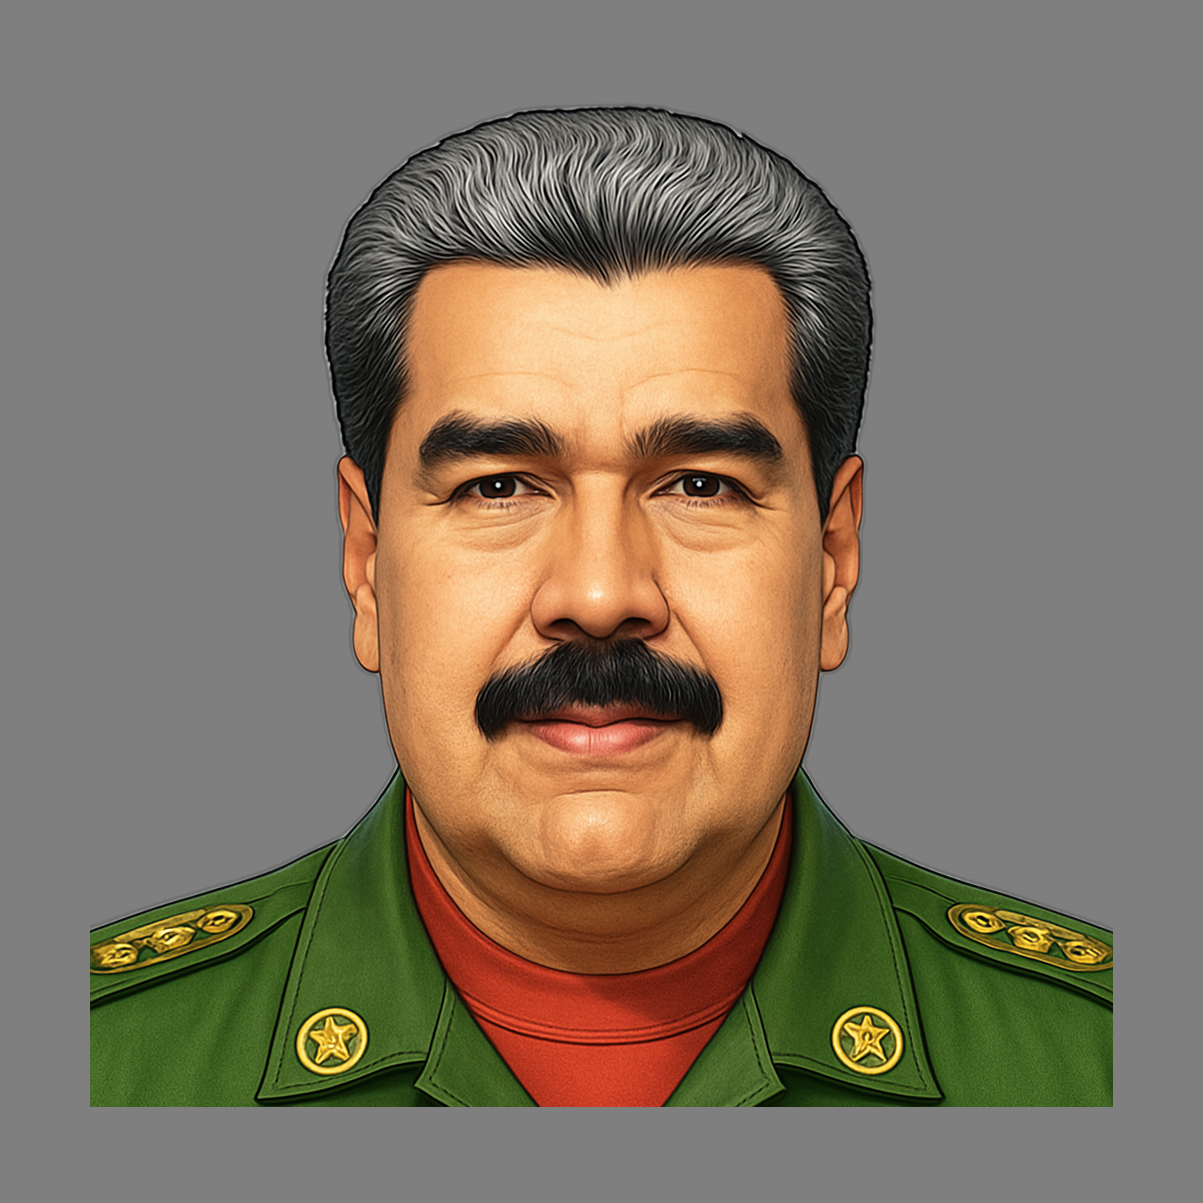

{'event_id': '02451a61-54c3-4074-8d57-b9c4e9270cec',
 'timestamp': 1754379431.510327,
 'event_name': 'SubidaImagenIniciada',
 'payload': {'input_image_path': '/content/ChatGPT Image 31 jul 2025, 05_07_24 p.m..png'}}

In [ ]:
emit_event("SubidaImagenIniciada", {
    "input_image_path": f"/content/{filename}"
})

In [ ]:

# ╔════════════════════════════════════════════╗
# ║  7. Exportar ZIP                           ║
# ╚════════════════════════════════════════════╝
@consume_event("Modelo3DGenerado")
def empaquetar_resultados(event):
    zip_path = "/content/TripoSR_results.zip"
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(OUTPUT_DIR):
            for file in files:
                path = os.path.join(root, file)
                arcname = os.path.relpath(path, OUTPUT_DIR)
                zipf.write(path, arcname)
    emit_event("ResultadosListos", {"zip_path": zip_path})

@consume_event("ResultadosListos")
def descargar(event):
    print(f"⬇️ Descargando: {event['payload']['zip_path']}")
    files.download(event['payload']['zip_path'])


In [ ]:
# ╔════════════════════════════════════════════╗
# ║  8. Ejecutar Flujo                         ║
# ╚════════════════════════════════════════════╝
subir_imagen()